In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from bs_fdbck_clean.constants import path_extract_latlon_outdata
from dask.diagnostics import ProgressBar
import seaborn as sns
import numpy as np
import pandas as pd
from bs_fdbck_clean.constants import path_measurement_data

from bs_fdbck_clean.util.BSOA_datamanip import compute_total_tau, broadcase_station_data, change_units_and_compute_vars, \
    get_dic_df_mod
 
xr.set_options(keep_attrs=True) 
import numpy as np
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/bs_fdbck_clean/data_info


In [2]:
from bs_fdbck_clean.util.BSOA_datamanip.atto import season2month

In [3]:
import scienceplots
plt.style.use([
    'default',
    #'science',
    #'acp',
    'nature',
    # 'sp-grid',
    'no-black',
    'no-latex',
    'illustrator-safe'
])

In [4]:
%load_ext autoreload
%autoreload 2

## SET SEASON

In [5]:
season = 'FMA'

### Filename for saved plots

In [6]:
def make_fn(case, v_x, v_y, comment='', relplot = False, distplot=False):
    _x = v_x.split('(')[0]
    _y = v_y.split('(')[0]
    f = f'cloud_props_{comment}_{case}_{_x}_{_y}_{season}.png'
    if relplot:
        return plot_path_relplot/f
    if distplot:
        return plot_path_distplot/f

    return plot_path /f




plot_path = Path('Plots')
plot_path.mkdir(parents=True, exist_ok=True) 

plot_path_distplot = plot_path/'dist_plot'
plot_path_distplot.mkdir(parents=True, exist_ok=True) 

plot_path_relplot = plot_path/'rel_plot'
plot_path_relplot.mkdir(parents=True, exist_ok=True) 

## Load observational data

In [7]:
import pandas as pd
import numpy as np
import rioxarray as rxr
import xarray as xr
from pathlib import Path 
import time
import netCDF4

In [8]:
rn_dic = {
    'Cloud_Optical_Thickness_Liquid_Mean':'COT',
    'Cloud_Effective_Radius_Liquid_Mean': 'r_eff',
    'Cloud_Water_Path_Liquid_Mean': 'CWP',
}

In [9]:
produce_files = [
    'Cloud_Optical_Thickness_Liquid_Mean', 
    'Cloud_Effective_Radius_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean_Uncertainty',
    'Cloud_Water_Path_Liquid_Standard_Deviation',
    'Cloud_Water_Path_Liquid_Maximum',
    'Cloud_Water_Path_Liquid_Minimum',
]

In [10]:
from bs_fdbck_clean.constants import path_measurement_data

## Settings: 

In [11]:
path_out_postproc = path_measurement_data /'satellite' / 'MODIS_postproc'
path_out_postproc_lev2 = path_measurement_data /'satellite' / 'MODIS_postproc_lev2'

station = 'ATTO'
sat_filename = path_out_postproc_lev2 / f'MODIS_date_{station}.nc'


fl = list(path_out_postproc.glob('*.nc'))
fl.sort()

In [12]:
ds_smr_sat = xr.open_dataset(sat_filename)

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
(click 8.0.1 (/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages), Requirement.parse('click<8,>=4.0'), {'rasterio'})
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [13]:
ds_smr_sat

<xarray.Dataset>
Dimensions:                                     (time: 2555, LAT: 7, LON: 15)
Coordinates:
  * time                                        (time) datetime64[ns] 2012-01...
  * LAT                                         (LAT) float64 -1.5 -2.5 ... -7.5
  * LON                                         (LON) float64 -66.5 ... -52.5
    band                                        int64 ...
Data variables: (12/20)
    CER (micrometer)                            (time, LAT, LON) float32 ...
    COT                                         (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Maximum           (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Mean              (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Minimum           (time, LAT, LON) float32 ...
    Cloud_Water_Path_Liquid_Maximum             (time, LAT, LON) float32 ...
    ...                                          ...
    N50-500                                     (time) float64 ...
    N100-500                                    (time) float64 ...
    N200-500                                    (time) float64 ...
    BC_conc                                     (time) float64 ...
    day_of_year                                 (time) float64 ...
    hour                                        (time) float64 ...

## Annual distribution

In [14]:
dic_nice_ylabel = {
    'COT':'COT []',
    'CWP (g m^-2)':'CWP [gm$^{-2}$]', 
    'OA (microgram m^-3)':'OA [$\mu$gm$^{-3}$]',
    'CER (micrometer)':'r$_{\mathrm{eff}}$ [$\mu$m]',
}

COT
CWP (g m^-2)
OA (microgram m^-3)
CER (micrometer)
Plots/dist_plot/cloud_props__annual_distribution_props_percentiles_FMA.png


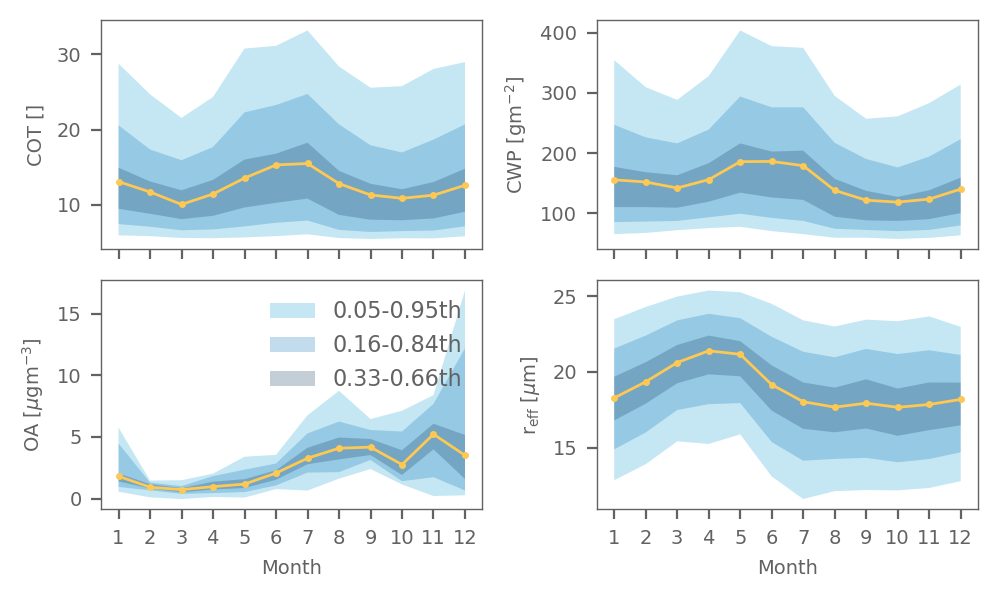

In [15]:
_df = ds_smr_sat.sel(time=slice('2014-01-01','2018-01-01')).to_dataframe()

  #  v_x = 'COT'
fig, axs = plt.subplots(2,2, dpi=200, sharex=True, figsize=[5,3])
    

    
_ds_d = _df.copy().to_xarray()
_ds_d['time'] = pd.to_datetime(_ds_d['time'])

_ds_d['month'] = _ds_d['time.month']

for v_x, ax in zip(['COT','CWP (g m^-2)', 'OA (microgram m^-3)','CER (micrometer)'], axs.flatten()):
        print(v_x)
        #st_dev = _ds_d[v_x].mean(['LAT','LON']).groupby(_ds_d['month']).std()
        #_dfmq = _ds_d[v_x].mean(['LAT','LON']).groupby(_ds_d['month']).quantile([0.05,.33,.5, .66, .95])   
        _dfmq = _ds_d.to_dataframe().reset_index().groupby('month').quantile([0.05,.16, .33,.5, .66, .84,.95]).to_xarray().rename({'level_1':'quantile'})[v_x]
        mean = _ds_d[v_x].mean(['LAT','LON']).groupby(_ds_d['month']).median()
        ax.fill_between(_dfmq.month, _dfmq.sel(quantile=0.05), _dfmq.sel(quantile=0.95),  alpha=.25, label='0.05-0.95th', color='#14a0d2', edgecolor=None)
        ax.fill_between(_dfmq.month, _dfmq.sel(quantile=0.16), _dfmq.sel(quantile=0.84),  alpha=.25, label= '0.16-0.84th', color='#0d71ba', edgecolor=None)
        ax.fill_between(_dfmq.month, _dfmq.sel(quantile=0.33), _dfmq.sel(quantile=0.66),  alpha=.25, label= '0.33-0.66th', color= '#123c5f', edgecolor=None)
        mean.plot(ax = ax, alpha=1, marker='.', c='#fdc854') 
        ax.set_ylabel(dic_nice_ylabel[v_x])
fig.tight_layout()
axs[-1,0].legend(frameon=False, fontsize=8)#bbox_to_anchor=(1,1,))
ax.set_xticks(list(range(1,13)))
for ax in axs.flatten():
    ax.set_xlabel('')
    
for ax in axs[-1,:]:
    ax.set_xlabel('Month')
    
ax.set_xticks(np.arange(1,13), minor=True)
fig.tight_layout()
fn = make_fn('annual_distribution', 'props','percentiles', distplot=True)
print(fn)
fig.savefig(fn)
plt.show()

### Filter data for season

In [16]:
ds_smr_sat['is_season'] = ds_smr_sat['time.month'].isin(season2month[season])

In [17]:
ds_smr_sat_JA = ds_smr_sat.where(ds_smr_sat['is_season'], drop=True)

In [18]:
varsl = ['OA (microgram m^-3)', 'CWP (g m^-2)',
       'CER (micrometer)', 'COT',]

### Broadcast OA to full grid: 

In [19]:
ds_smr_sat_JA['OA (microgram m^-3)'],_ =xr.broadcast(ds_smr_sat_JA['OA (microgram m^-3)'],ds_smr_sat_JA['COT'])

In [20]:
ds_smr_sat_JA[varsl]

<xarray.Dataset>
Dimensions:              (time: 625, LAT: 7, LON: 15)
Coordinates:
  * time                 (time) datetime64[ns] 2012-02-01 ... 2018-04-30
  * LAT                  (LAT) float64 -1.5 -2.5 -3.5 -4.5 -5.5 -6.5 -7.5
  * LON                  (LON) float64 -66.5 -65.5 -64.5 ... -54.5 -53.5 -52.5
    band                 int64 1
Data variables:
    OA (microgram m^-3)  (time, LAT, LON) float64 nan nan nan ... nan nan nan
    CWP (g m^-2)         (time, LAT, LON) float32 nan nan nan ... nan nan nan
    CER (micrometer)     (time, LAT, LON) float32 nan nan nan ... nan nan nan
    COT                  (time, LAT, LON) float32 nan nan nan ... nan nan nan

In [21]:
ds_smr_sat_JAs = ds_smr_sat_JA[varsl]#.rename({'x':'LON','y':'LAT'})#.isel(band=0)

### Drop pixels with few obs:

In [22]:
_df = ds_smr_sat_JAs.to_dataframe().drop('band', axis=1)

df_smr_sat_JAs = _df.dropna()

In [23]:
_df = df_smr_sat_JAs.reset_index()
da_cnt= _df.groupby([_df['LAT'],_df['LON']]).count().to_xarray()['OA (microgram m^-3)']#.plot()
da_drop_pixels = ~da_cnt.where(da_cnt>2).notnull()

In [24]:
ds_smr_sat_JAs = ds_smr_sat_JAs.where(~da_drop_pixels)

### Rename and reorganise dataset:

In [25]:
_df = (ds_smr_sat_JAs
       .drop('band')
       .to_dataframe()
       .reset_index()
       .rename({'LAT':'lat','LON':'lon'},axis=1)
      )
df_hyy_1 = _df.sort_values(['lat','lon']).set_index(['time','lat','lon'])

In [26]:
df_hyy_1.head()

,,,OA (microgram m^-3),CWP (g m^-2),CER (micrometer),COT
time,lat,lon,,,,
2012-02-01,-7.5,-66.5,NaN,127.0,22.769999,9.09
2012-02-02,-7.5,-66.5,NaN,NaN,NaN,NaN
2012-02-03,-7.5,-66.5,NaN,NaN,NaN,NaN
2012-02-04,-7.5,-66.5,NaN,NaN,NaN,NaN
2012-02-05,-7.5,-66.5,NaN,132.0,17.469999,11.24


df_smr_sat_JAsad model data:

## Load model data

In [27]:
model_name_noresm = 'NorESM'
model_name_echam  = 'ECHAM-SALSA' 
model_name_ec_earth  = 'EC-Earth' 
model_name_ukesm  = 'UKESM'

models =[model_name_noresm,model_name_echam,model_name_ec_earth,model_name_ukesm]

### Some definitions

In [28]:
lon_lims = [293.,308.]
lat_lims = [-8.,-1.]

In [29]:
lon_lims = [293.,308.]
lat_lims = [-8.,-1.]

In [30]:
str_lonlim = '%.1f-%.1f'%(*lon_lims,)
str_latlim = '%.1f-%.1f'%(*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'
str_coordlims

'293.0-308.0_-8.0--1.0'

### NorESM

In [31]:
from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 ='2015-01-01'
to_time2 ='2019-01-01'

In [32]:
case_name_noresm = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'
model_name_noresm = 'NorESM'



#### Input files created in [03-01-01-create_file_ATTO.ipynb](03-01-01-create_file_ATTO.ipynb)

#### Input files

In [33]:
input_path_noresm = path_extract_latlon_outdata / model_name_noresm / case_name_noresm 

In [34]:
fn_noresm_csv = input_path_noresm / f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_finalALL_year.csv'

In [35]:
cases_noresm = [case_name_noresm]

### ECHAM-SALSA

In [36]:
case_name = 'SALSA_BSOA_feedback'
case_name_echam = 'SALSA_BSOA_feedback'
time_res = 'hour'
space_res='locations'
model_name='ECHAM-SALSA'

#### Define some strings for files

In [37]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')

#### Input files:

In [38]:
input_path_echam = path_extract_latlon_outdata / model_name_echam / case_name_echam 

In [39]:
fn_final_echam_csv = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'
print(fn_final_echam_csv)

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/ECHAM-SALSA/SALSA_BSOA_feedback/SALSA_BSOA_feedback_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0ALL_year.csv


In [40]:
cases_echam = [case_name_echam]

### EC-Earth

In [41]:
case_name = 'ECE3_output_Sara'
case_name_ec_earth = 'ECE3_output_Sara'
time_res = 'hour'
space_res='locations'
model_name='EC-Earth'
model_name_ec_earth ='EC-Earth'

#### Define some strings for files

In [42]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')

#### Input files:

In [43]:
input_path_ec_earth = path_extract_latlon_outdata / model_name_ec_earth/ case_name_ec_earth

In [44]:
fn_final_ec_earth_csv = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

In [45]:
fn_final_ec_earth_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0ALL_year.csv')

In [46]:
cases_ec_earth = [case_name_ec_earth]

### UKESM

In [47]:
case_name = 'AEROCOMTRAJ'
case_name_ukesm = 'AEROCOMTRAJ'
time_res = 'hour'
space_res='locations'
model_name='UKESM'
model_name_ukesm ='UKESM'

#### Define some strings for files

In [48]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')

#### Input files:

In [49]:
input_path_ukesm = path_extract_latlon_outdata / model_name_ukesm/ case_name_ukesm

In [50]:
fn_final_ukesm_csv = input_path_ukesm / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

In [51]:
cases_ukesm = [case_name_ukesm]

### Read in model data

In [52]:
df_mod_noresm = pd.read_csv(fn_noresm_csv, index_col=[0,1,2],parse_dates=[0] )
df_mod_noresm['month'] =df_mod_noresm.index.get_level_values(0).month
df_mod_echam = pd.read_csv(fn_final_echam_csv, index_col=[0,1,2], parse_dates=[0] )
df_mod_echam['month'] =df_mod_echam.index.get_level_values(0).month
df_mod_ec_earth = pd.read_csv(fn_final_ec_earth_csv, index_col=[0,1,2], parse_dates=[0] )
df_mod_ec_earth['month'] =df_mod_ec_earth.index.get_level_values(0).month
df_mod_ukesm = pd.read_csv(fn_final_ukesm_csv, index_col=[0,1,2], parse_dates=[0] )
df_mod_ukesm['month'] =df_mod_ukesm.index.get_level_values(0).month

## Pick out months:

In [53]:
df_mod_noresm = df_mod_noresm[df_mod_noresm['month'].isin(season2month[season])]
df_mod_echam = df_mod_echam[df_mod_echam['month'].isin(season2month[season])]
df_mod_ec_earth = df_mod_ec_earth[df_mod_ec_earth['month'].isin(season2month[season])]
df_mod_ukesm =df_mod_ukesm[df_mod_ukesm['month'].isin(season2month[season])] 

### Organize data in dictionary

In [54]:
dic_df=dict()
dic_df[model_name_echam] = df_mod_echam
dic_df[model_name_noresm] = df_mod_noresm
dic_df[model_name_ec_earth] = df_mod_ec_earth
dic_df[model_name_ukesm] = df_mod_ukesm
dic_df['Observations'] = df_hyy_1



## Check everythign is fine:

In [55]:
for mod in dic_df.keys():
    print(dic_df[mod].to_xarray())

<xarray.Dataset>
Dimensions:         (time: 625, lat: 3, lon: 8)
Coordinates:
  * time            (time) datetime64[ns] 2012-02-01 2012-02-02 ... 2018-04-30
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/55)
    station         (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO' 'ATTO'
    lcdnc           (time, lat, lon) float64 4.999e-29 1.137e-28 ... 5.342e-29
    COT             (time, lat, lon) float64 11.33 7.694 nan ... nan 9.523 16.68
    clfr_mask       (time, lat, lon) float64 1.0 1.0 nan 1.0 ... 1.0 nan 1.0 1.0
    CWP             (time, lat, lon) float64 135.0 96.62 nan ... nan 105.4 139.4
    lcdnc_ct_cm3    (time, lat, lon) float64 1.566 1.009 nan ... nan 12.3 12.52
    ...              ...
    N50-500         (time, lat, lon) float64 316.2 316.2 316.2 ... 258.6 258.6
    mmrtrN200       (time, lat, lon) float64 2.762e+07 2.762e+07 ... 1.156e+07
    N100            (ti

## Rename variables:


In [56]:
rn_dic_echam = {
    #'cwp'      : 'CWP',
   # 'cwp_incld'      : 'CWP',
   # 'cod'      : 'COT',
    #'ceff_ct'  : 'r_eff',
   # 'ceff_ct_incld'  : 'r_eff',
    'OA_STP':'OA',


}
rn_dic_ukesm = {
    #'cwp'      : 'CWP',
   # 'cwp_incld'      : 'CWP',
   # 'cod'      : 'COT',
    #'ceff_ct'  : 'r_eff',
   # 'ceff_ct_incld'  : 'r_eff',
    'OA_STP':'OA',


}
rn_dic_noresm = {
    'TGCLDLWP_incld'         : 'CWP',
    'TOT_CLD_VISTAU_s_incld': 'COT',
    'ACTREL_incld'     : 'r_eff',
    'OA_STP':'OA',
}
rn_dic_obs = {
    'CWP (g m^-2)'        : 'CWP',
    'CER (micrometer)'    : 'r_eff',
    'OA (microgram m^-3)' : 'OA',
    
}
rn_dic_ec_earth = {
    'OA_STP':'OA',
}

In [57]:
model2rndic = {
    model_name_noresm : rn_dic_noresm,
    model_name_ec_earth: rn_dic_ec_earth,
    model_name_echam:rn_dic_echam,
    model_name_ukesm:rn_dic_ukesm,
    'Observations': rn_dic_obs
}

#### Fix NorESM having OA as well as OA_STP

In [58]:
for mod in models+ ['Observations']:
    _rn_dic = model2rndic[mod]
    print(mod)
    print(_rn_dic)
    if ('OA' in dic_df[mod].columns) & ('OA_STP' in dic_df[mod].columns):
        if ('OA_STP' in _rn_dic):
            if (_rn_dic['OA_STP']=='OA'):
                dic_df[mod] = dic_df[mod].drop(['OA'], axis=1)
                print('dropping OA in favor of OA_STP')
    dic_df[mod] = dic_df[mod].rename(_rn_dic, axis=1)

NorESM
{'TGCLDLWP_incld': 'CWP', 'TOT_CLD_VISTAU_s_incld': 'COT', 'ACTREL_incld': 'r_eff', 'OA_STP': 'OA'}
dropping OA in favor of OA_STP
ECHAM-SALSA
{'OA_STP': 'OA'}
EC-Earth
{'OA_STP': 'OA'}
UKESM
{'OA_STP': 'OA'}
dropping OA in favor of OA_STP
Observations
{'CWP (g m^-2)': 'CWP', 'CER (micrometer)': 'r_eff', 'OA (microgram m^-3)': 'OA'}


## Group by cloud water path 

#### Predefined bins

In [59]:
dic_bins = dict()
dic_bins[model_name_noresm] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_echam] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_ec_earth] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_ukesm] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins['Observations'] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])




### Bin model data:

CWP above 50. 

In [60]:
varl_categories = ['OA']#,'CLDFREE'

In [61]:
varlist_notna = ['OA','CWP','COT','r_eff']
varlist_notna_noCOT = set(varlist_notna)-set(['COT'])

In [62]:
dic_OA_percentiles = dict()

In [63]:
n_bins = 7

for model_name in dic_df.keys():

    print(model_name)
    df_mod = dic_df[model_name].copy()
    ## drop nans:
    if model_name in ['UKESM','EC-Earth']:
        _vl = varlist_notna_noCOT
    else:
        _vl = varlist_notna
    df_mod = df_mod[df_mod[_vl].replace([np.inf, -np.inf], np.nan).notna().all(axis=1)]


    for v in varl_categories:
        q34 = df_mod[v].quantile(.3333333)
        print(q34)

        q66 = df_mod[v].quantile(.6666666)
        print(q66)
        if v=='OA':
            dic_OA_percentiles[model_name]=dict()
            dic_OA_percentiles[model_name]['33rd']=q34
            dic_OA_percentiles[model_name]['66th']=q66
            dic_OA_percentiles[model_name]['med_high']= df_mod[v][df_mod[v]>q66].median()
            dic_OA_percentiles[model_name]['med_low']= df_mod[v][df_mod[v]<q34].median()


        df_mod[f'{v}_low'] = df_mod[v]<q34
        df_mod[f'{v}_high']= df_mod[v]>q66
        mid_range = ( q34<df_mod[v]) & (df_mod[v]<q66)
        df_mod[f'{v}_mid_range'] = mid_range
        df_mod=df_mod.assign(**{f'{v}_category': pd.NA})
        df_mod.loc[df_mod[f'{v}_high'], f'{v}_category'] = f'{v} high'
        df_mod.loc[df_mod[f'{v}_low'], f'{v}_category'] = f'{v} low'

    bins = dic_bins[model_name]
    df_mod['CWP_cut']=pd.cut(df_mod['CWP'], bins=bins)#, labels=labels)

    
    df_mod['CWP_cutl'] = df_mod['CWP_cut'].apply(lambda x:x.mid)
    di = dict(df_mod.groupby('CWP_cut').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cutlm'] = df_mod['CWP_cut'].apply(lambda x:di[x])
    
    labels = np.arange(n_bins)
    # bins from 5th to 95th percentile
    qants = df_mod['CWP'].quantile([.0,.95])
    bins2 = pd.interval_range(qants.iloc[0], qants.iloc[1], periods=n_bins)
    bins2.values[-1] = pd.Interval(bins2[-1].left,np.inf)
    bins2.values[0] = pd.Interval(0,bins2[0].right)
 
    df_mod['CWP_cut2']=pd.cut(df_mod['CWP'], bins=bins2, labels=labels)
    di_per_lab = {bins2[i]:labels[i] for i in range(len(labels))}

    df_mod['CWP_cut2l'] = df_mod['CWP_cut2'].apply(lambda x:di_per_lab[x])
    # median label: 
    di = dict(df_mod.groupby('CWP_cut2').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cut2lm'] = df_mod['CWP_cut2'].apply(lambda x:di[x])
    
    #di = dict(df_mod.groupby('CWP_cut2').unique().mid)
    #for k in di.keys():
    #    di[k] = int(np.round(di[k]))
    df_mod['CWP_cut2lmid'] = df_mod['CWP_cut2'].apply(lambda x:np.round(x.mid))
    
    dic_df[model_name] = df_mod

ECHAM-SALSA
0.884104785
2.1047842
NorESM
4.07563026472634
6.425356142615152
EC-Earth


/tmp/ipykernel_2859266/4114429425.py:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_mod = df_mod[df_mod[_vl].replace([np.inf, -np.inf], np.nan).notna().all(axis=1)]
/tmp/ipykernel_2859266/4114429425.py:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_mod = df_mod[df_mod[_vl].replace([np.inf, -np.inf], np.nan).notna().all(axis=1)]


2.1126693120418074
2.6052923346251653
UKESM
2.2233200401162576
2.756548923025378
Observations
0.69256325
1.1680000000000001


/tmp/ipykernel_2859266/4114429425.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod[f'{v}_low'] = df_mod[v]<q34
/tmp/ipykernel_2859266/4114429425.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod[f'{v}_high']= df_mod[v]>q66
/tmp/ipykernel_2859266/4114429425.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [64]:
OA_percentile_df = pd.DataFrame(dic_OA_percentiles).T
OA_percentile_df['diff'] = OA_percentile_df['66th']- OA_percentile_df['33rd']

fn = make_fn('percentile_OA', 'OA','perc').with_suffix('.csv')
OA_percentile_df.to_csv(fn)

print(fn)
OA_percentile_df

Plots/cloud_props__percentile_OA_OA_perc_FMA.csv


,33rd,66th,med_high,med_low,diff
ECHAM-SALSA,0.884105,2.104784,3.084420,0.455112,1.220679
NorESM,4.075630,6.425356,8.583221,2.965201,2.349726
EC-Earth,2.112669,2.605292,2.915669,1.888359,0.492623
UKESM,2.223320,2.756549,3.167057,2.015614,0.533229
Observations,0.692563,1.168000,1.584301,0.467500,0.475437


## Quantile cut

In [65]:
for key in dic_df.keys():
    df_mod = dic_df[key]
    df_mod['CWP_qcut']=pd.qcut(df_mod['CWP'],6)# bins=bins, labels=labels)§
    df_mod['CWP_qcutl'] = df_mod['CWP_qcut'].apply(lambda x:x.mid)
    dic_df[key] = df_mod

In [66]:
pd.qcut(df_mod['CWP'][df_mod['CWP']<np.inf], 6)

time        lat   lon  
2014-03-11  -7.5  -66.5    (232.0, 638.0]
2014-03-15  -7.5  -66.5    (141.0, 175.0]
2014-03-19  -7.5  -66.5    (113.0, 141.0]
2014-03-25  -7.5  -66.5    (113.0, 141.0]
2014-04-01  -7.5  -66.5    (113.0, 141.0]
                                ...      
2017-03-18  -1.5  -52.5    (141.0, 175.0]
2017-03-27  -1.5  -52.5     (90.0, 113.0]
2017-04-07  -1.5  -52.5     (90.0, 113.0]
2017-04-09  -1.5  -52.5    (49.999, 90.0]
2017-04-11  -1.5  -52.5     (90.0, 113.0]
Name: CWP, Length: 3549, dtype: category
Categories (6, interval[float64, right]): [(49.999, 90.0] < (90.0, 113.0] < (113.0, 141.0] < (141.0, 175.0] < (175.0, 232.0] < (232.0, 638.0]]

# Distribution plots:

In [67]:
palette = 'Set2'
cmap_list = ['#441FE0','#BBE01F'][::-1]#cmap(a) for a in np.linspace(0,1,8)]
palette_OA = cmap_list[0:2]

In [68]:
for key in dic_df.keys():
    _df = dic_df[key].copy()
    #_df = _df[_df[v_x]<x_cut]
    print(key)
    print(len(_df.dropna().reset_index()['time'].unique()))
    #_df.reset_index()['time'].unique().plot()

ECHAM-SALSA
414
NorESM
372
EC-Earth
381
UKESM
272
Observations
69


3549
Plots/dist_plot/cloud_props_distribution_mod_obs_COT_count_FMA.png


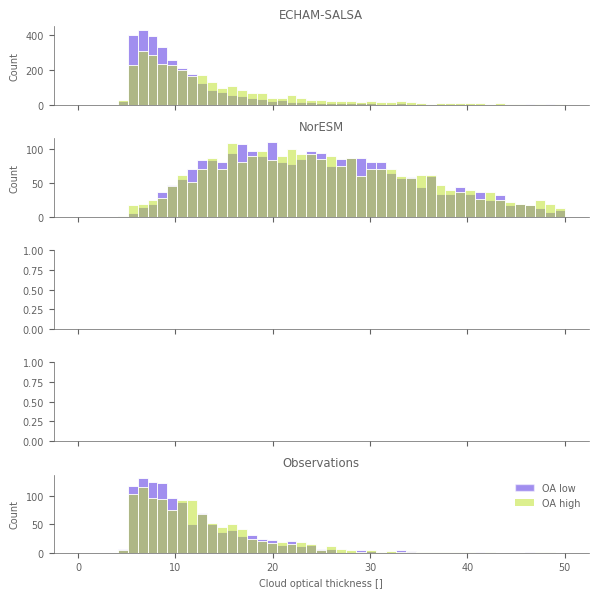

In [69]:
fig, axs = plt.subplots(5,1, sharex=True, figsize =[6,6])
v_x = 'COT'
x_cut = 100
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]
_bins = np.linspace(0,50)
_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    if key in ['EC-Earth','UKESM']:
        continue
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax,
        bins=_bins,
    )
#plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud optical thickness []')
#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



3549
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_FMA.png


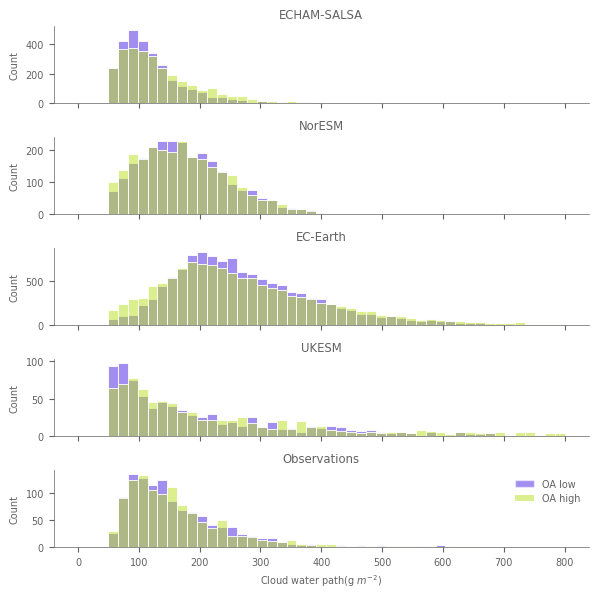

In [70]:
fig, axs = plt.subplots(5,1, sharex=True, figsize =[6,6])
_bins = np.linspace(0,800)
v_x = 'CWP'
x_cut = 800
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax,
        bins = _bins,
    )
    if (key=='EC-Earth') and ('scaled' in _df.columns):
        title = f'{key}$\cdot$0.7'
    else:
        title = key
#plt.ylim([0,250])
    ax.set_title(title)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



3549
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_FMA.png


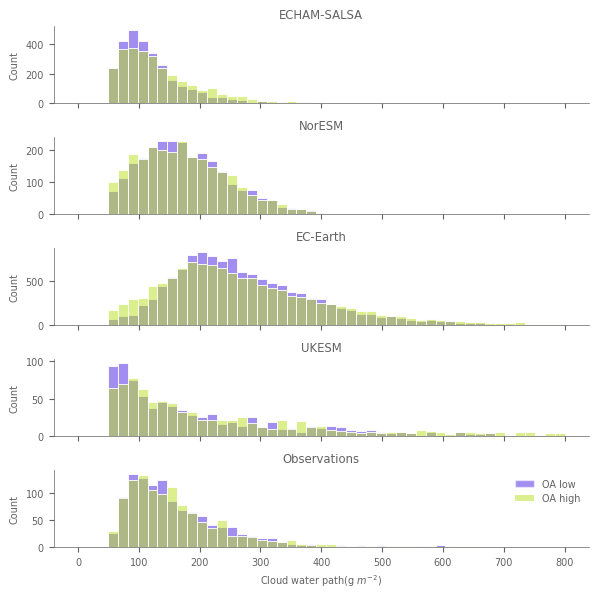

In [71]:
fig, axs = plt.subplots(5,1, sharex=True, figsize =[6,6])
_bins = np.linspace(0,800)
v_x = 'CWP'
x_cut = 800
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax,
        bins = _bins,
    )
    if (key=='EC-Earth') and ('scaled' in _df.columns):
        title = f'{key}$\cdot$0.7'
    else:
        title = key
#plt.ylim([0,250])
    ax.set_title(title)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



3546
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_FMA.png


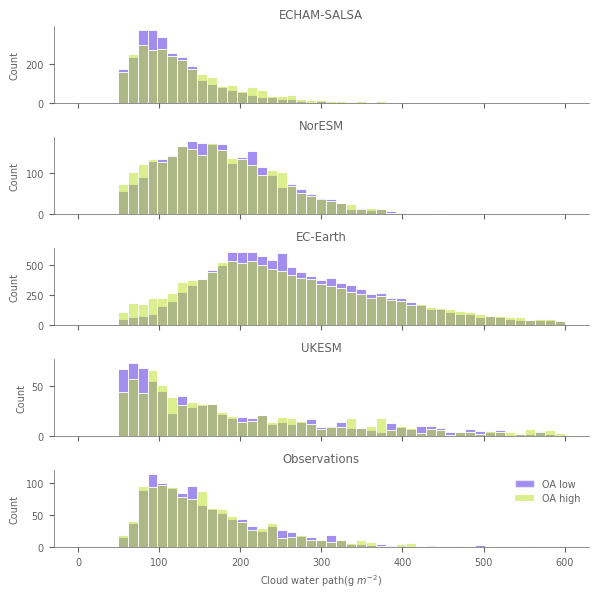

In [72]:
fig, axs = plt.subplots(5,1, sharex=True, figsize =[6,6])
_bins = np.linspace(0,600)
v_x = 'CWP'
x_cut = 600
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax,
        bins = _bins,
    )
    if (key=='EC-Earth') and ('scaled' in _df.columns):
        title = f'{key}$\cdot$0.7'
    else:
        title = key
#plt.ylim([0,250])
    ax.set_title(title)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



1135
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_FMA.png


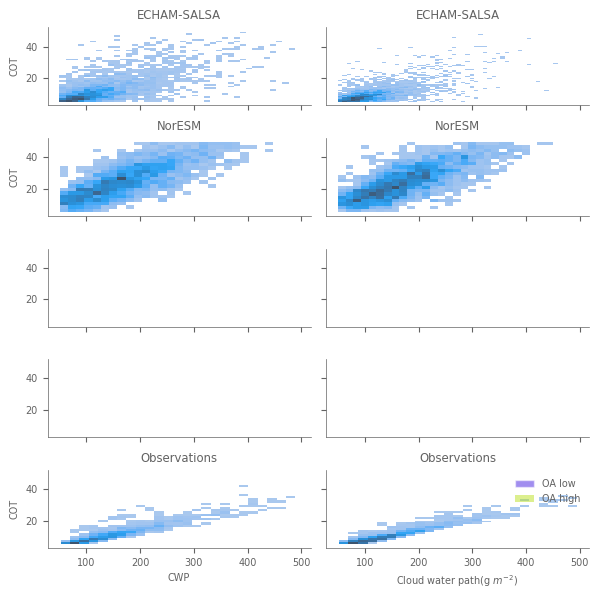

In [73]:
fig, axs = plt.subplots(5,2,  figsize =[6,6], sharex=True, sharey=True)

v_x = 'CWP'
v_y = 'COT'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for i, key in enumerate(dic_df.keys()):
    if key in ['EC-Earth','UKESM']:

        continue
    axs_sub = axs[i,:]
    for hue_v, ax in zip(hue_order, axs_sub):
        _df = dic_df[key].copy()
        _df = _df[_df[v_x]<x_cut]
        _df = _df[_df[v_hue]==hue_v]
    
        sns.histplot(
            x=v_x,
            y=v_y, 
            data=_df,
            #hue=v_hue,
            #hue_order=hue_order,
#            palette=_palette,
            legend=False,
        #edgecolor='w',
        ax = ax
        )
        #plt.ylim([0,250])
        ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)



1135
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_FMA.png


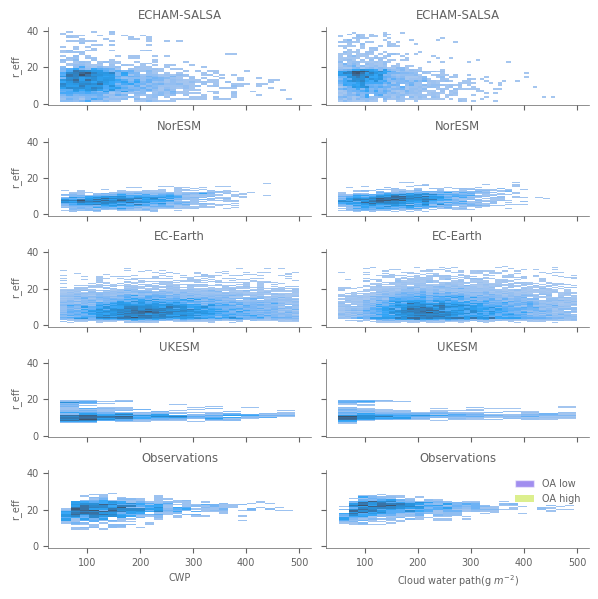

In [74]:
fig, axs = plt.subplots(5,2,  figsize =[6,6], sharex=True, sharey=True)

v_x = 'CWP'
v_y = 'r_eff'
x_cut = 500
y_cut = 40
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for i, key in enumerate(dic_df.keys()):
    #if key=='EC-Earth':
    #    continue
    axs_sub = axs[i,:]
    for hue_v, ax in zip(hue_order, axs_sub):
        _df = dic_df[key].copy()
        _df = _df[_df[v_x]<x_cut]
        _df = _df[_df[v_y]<y_cut]
        _df = _df[_df[v_hue]==hue_v]
    
        sns.histplot(
            x=v_x,
            y=v_y, 
            data=_df,
            #hue=v_hue,
            #hue_order=hue_order,
#            palette=_palette,
            legend=False,
        #edgecolor='w',
        ax = ax
        )
        #plt.ylim([0,250])
        ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)



8511
7572
35510
2477
3549
Plots/dist_plot/cloud_props_distribution_mod_obs_r_eff_count_FMA.png


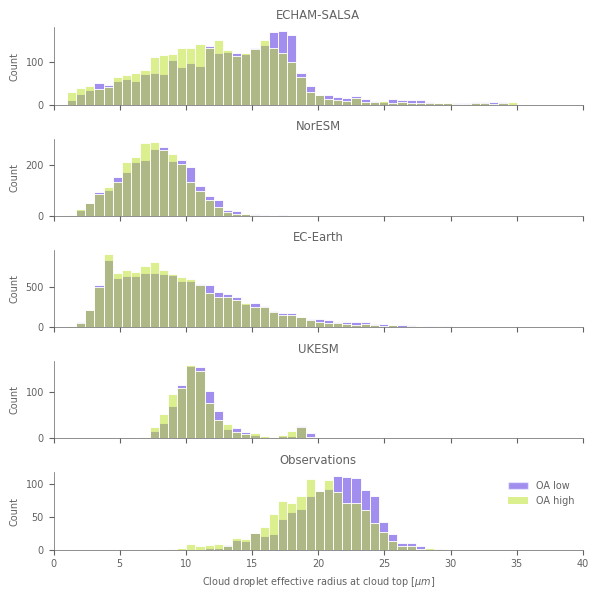

In [75]:
fig, axs = plt.subplots(5,1, sharex=True, figsize =[6,6], dpi=100)

v_x = 'r_eff'
x_cut = 700
_bins = np.linspace(1, 35)
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]
_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    _df = _df[_df[v_x]>0]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        bins = _bins,
        ax = ax
    )
    #plt.ylim([0,250])
    ax.set_title(key)#'Observations')
    print(len(_df))
    


custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud droplet effective radius at cloud top [$\mu m$]')

#plt.ylim([0,250])
sns.despine(fig)

for ax in axs: 
    ax.set_xlim([0,40])
fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



# Calculate difference between high OA and low


In [76]:
from bs_fdbck_clean.util.plot.BSOA_plots import cdic_model

In [77]:
hue_order = ['OA low','OA high']#[::-1]
palette_OA_2 = palette_OA[::-1]

In [78]:
order_keys = [model_name_noresm, model_name_echam, 'Observations']

In [79]:
from sklearn.utils import resample

## Bootstrap resampling 

In [80]:
def bootstrap_subset(_df_low,_df_high, var='COT', category='CWP_cutlm', itts=10000):      
    


    cat_cats = list(_df_low[category][_df_low[category].notna()].unique())
    cat_cats.sort()

    df_sample_med = pd.DataFrame(columns=cat_cats, index = range(itts))

    df_sample_med

    for ca in cat_cats:
        _df_lc = _df_low[_df_low[category]==ca]
        _df_hc = _df_high[_df_high[category]==ca]
        print(f'length of {ca} is {len(_df_lc)} and {len(_df_hc)}')
        print(f'number of days is {len(_df_lc.reset_index().time.unique())} and {len(_df_hc.reset_index().time.unique())}')
        list_diff_meds = list()
        for it in range(itts):
            boot_l =resample(_df_lc[var])
            boot_h =resample(_df_hc[var])
    
            diff_median = boot_h.median()- boot_l.median()
            list_diff_meds.append(diff_median)
        print(len(list_diff_meds))
        df_sample_med[ca] = list_diff_meds
    
    return df_sample_med
    
def bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var='COT', category='CWP_cutlm', itts=10000):
    if quantiles is None:
        quantiles =[0.05, 0.5, 0.95]
    df_sample_med= bootstrap_subset(_df_low,_df_high, var=var, category=category, itts=itts)
    
    return df_sample_med.quantile(quantiles)
    
    
    #oob = [x for x in _df_low[var] if x not in boot]
    #print(resample(_df_low).median())
    #print(_df_low.median())
    
        

## Calculate CIs with bootstrap

In [81]:
hue_labs = ['OA low', 'OA high']
hue_var = 'OA_category'

itterations = 50000



x_var = 'CWP_cut2lm'
y_var1 = 'COT'
y_var2 = 'r_eff'



dic_median_CI = dict()
for ax, y_var in zip(axs,[y_var1, y_var2]):
    dic_median_CI[y_var] = dict()
    for key in dic_df.keys():
        print(key)
        if (key in ['EC-Earth', 'UKESM']) and (y_var=='COT'):
            continue
        _df = dic_df[key].copy()
    
        _df_lim =_df.copy() 
        notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
        _df_lim = _df_lim[notna]
        print('Total number of days:')
        print(len(_df_lim.reset_index()['time'].unique()))
        #_df_lim = _df_lim[_df_lim[y_var].notna()]
        #_df_lim = _df_lim[_df_lim[hue_var].notna()]
    
        _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
        _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
        
        med_low = _df_low.groupby(x_var).median()
        med_high = _df_high.groupby(x_var).median()
        #std_low = _df_low.groupby(x_var).std()
        #std_high = _df_high.groupby(x_var).std()
        n_low = _df_low.groupby(x_var).count()['OA_category']
        n_high = _df_high.groupby(x_var).count()['OA_category']
        df_numb = pd.DataFrame()
        df_numb['n_low'] = n_low
        df_numb['n_high'] = n_high
        df_numb['n_str'] = df_numb['n_low'].astype(str) + '/' + df_numb['n_high'].astype(str) 
        
    
    
        diff_med = med_high-med_low
        
        df_sample_quant =bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var=y_var, category=x_var, itts=itterations)
        #df_bs_samp_med = df_sample_quant.loc[0.5]
        dic_median_CI[y_var][key]=dict()
        dic_median_CI[y_var][key]['sample_median']=diff_med.copy()
        dic_median_CI[y_var][key]['bootstrap_quant']=df_sample_quant.copy()
        dic_median_CI[y_var][key]['number']=df_numb#['n_str']

ECHAM-SALSA
Total number of days:
414
length of 67 is 575 and 544
number of days is 180 and 202
50000
length of 93 is 855 and 658
number of days is 185 and 206
50000
length of 121 is 589 and 537
number of days is 179 and 200
50000
length of 149 is 330 and 365
number of days is 147 and 171
50000
length of 178 is 191 and 242
number of days is 114 and 134
50000
length of 207 is 117 and 171
number of days is 82 and 107
50000
length of 262 is 167 and 317
number of days is 95 and 144
50000
NorESM
Total number of days:
373
length of 72 is 233 and 315
number of days is 100 and 121
50000
length of 107 is 416 and 406
number of days is 137 and 146
50000
length of 143 is 517 and 464
number of days is 151 and 149
50000
length of 178 is 472 and 466
number of days is 143 and 143
50000
length of 216 is 389 and 344
number of days is 145 and 121
50000
length of 252 is 226 and 271
number of days is 114 and 109
50000
length of 308 is 263 and 249
number of days is 116 and 109
50000
EC-Earth
UKESM
Observati

## Save source data:

In [82]:
list_of_datasets_for_source_data = []

/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/bs_fdbck_clean/data_info


In [83]:
rename_dictionary_for_source_data = {
    'OA':'OA [ugm-3]',
    'COT':'COT []',
    'r_eff':'r_eff [um]',
}

In [89]:
varlist_out_all = ['OA','COT','r_eff']
varlist_out_no_COT = ['OA','r_eff']

hue_var = 'OA_category'
x_var = 'CWP_cut2lm'
y_var1 = 'COT'
y_var2 = 'r_eff'

for key in dic_df.keys():
    print(key)
    if (key in ['EC-Earth', 'UKESM']) :
        vl = varlist_out_no_COT
    else:
        vl = varlist_out_all        
    _df = dic_df[key][vl].copy()
     
    df_s_out = _df.copy()
    df_s_out['station'] = 'ATTO'
    df_s_out['data_source'] = key
    df_s_out = df_s_out.rename(rename_dictionary_for_source_data,axis=1)
    list_of_datasets_for_source_data.append(df_s_out.copy())
    
fn = make_fn(f'ATTO_data', 'fig4', '')
save_data_df = pd.concat(list_of_datasets_for_source_data,axis=0 )
save_data_df.to_csv(fn.with_suffix('.csv'))
print(fn.with_suffix('.csv'))
    


ECHAM-SALSA
NorESM
EC-Earth
UKESM
Observations
Plots/cloud_props__ATTO_data_fig4__FMA.csv


In [90]:
v = 'COT'
for source in dic_median_CI[v].keys():
    print(source)
    sa_med = dic_median_CI[v][source]['sample_median']

    sa_num = dic_median_CI[v][source]['number']

    sa_num['n_tot'] = sa_num['n_low'] + sa_num['n_high']
    _df_both = pd.concat([sa_med,sa_num], axis=1)
    
    fn = make_fn('sample_stats', 'OA',v, comment=source).with_suffix('.csv')
    _df_both.to_csv(fn)

    print((sa_med['COT']*sa_num['n_tot']).sum()/ sa_num['n_tot'].sum())

ECHAM-SALSA
1.5410170228084128
NorESM
0.9359440017889095
Observations
0.6203654828168735


In [91]:
dic_median_CI['r_eff'].keys()

dict_keys(['ECHAM-SALSA', 'NorESM', 'EC-Earth', 'UKESM', 'Observations'])

In [92]:
v = 'r_eff'
for source in dic_median_CI[v].keys():
    print(source)
    sa_med = dic_median_CI[v][source]['sample_median']

    sa_num = dic_median_CI[v][source]['number']

    sa_num['n_tot'] = sa_num['n_low'] + sa_num['n_high']
    _df_both = pd.concat([sa_med,sa_num], axis=1)
    
    fn = make_fn('sample_stats', 'OA',v, comment=source).with_suffix('.csv')
    _df_both.to_csv(fn)

    

ECHAM-SALSA
NorESM
EC-Earth
UKESM
Observations


In [93]:
dic_season_nicename = {
    'JFM':'Jan─Mar',
    'FMA':'Feb─Apr',
    'FMAM':'Feb─May',
    'JFMAM':'Jan─May',
    'MAM':'Mar─May',
    'JA':'July─Aug',
}

In [94]:
import scienceplots
import scienceplots
plt.style.use([
    'default',
    #'science',
    'acp',
    #'nature',
    # 'sp-grid',
    'no-black',
    'no-latex',
    'illustrator-safe'
])

In [95]:
import matplotlib as mpl

# Final plot: 

Plots/rel_plot/cloud_props_r_eff_diff_median_OA_category_COT_CWP_cut2lm_FMA.png


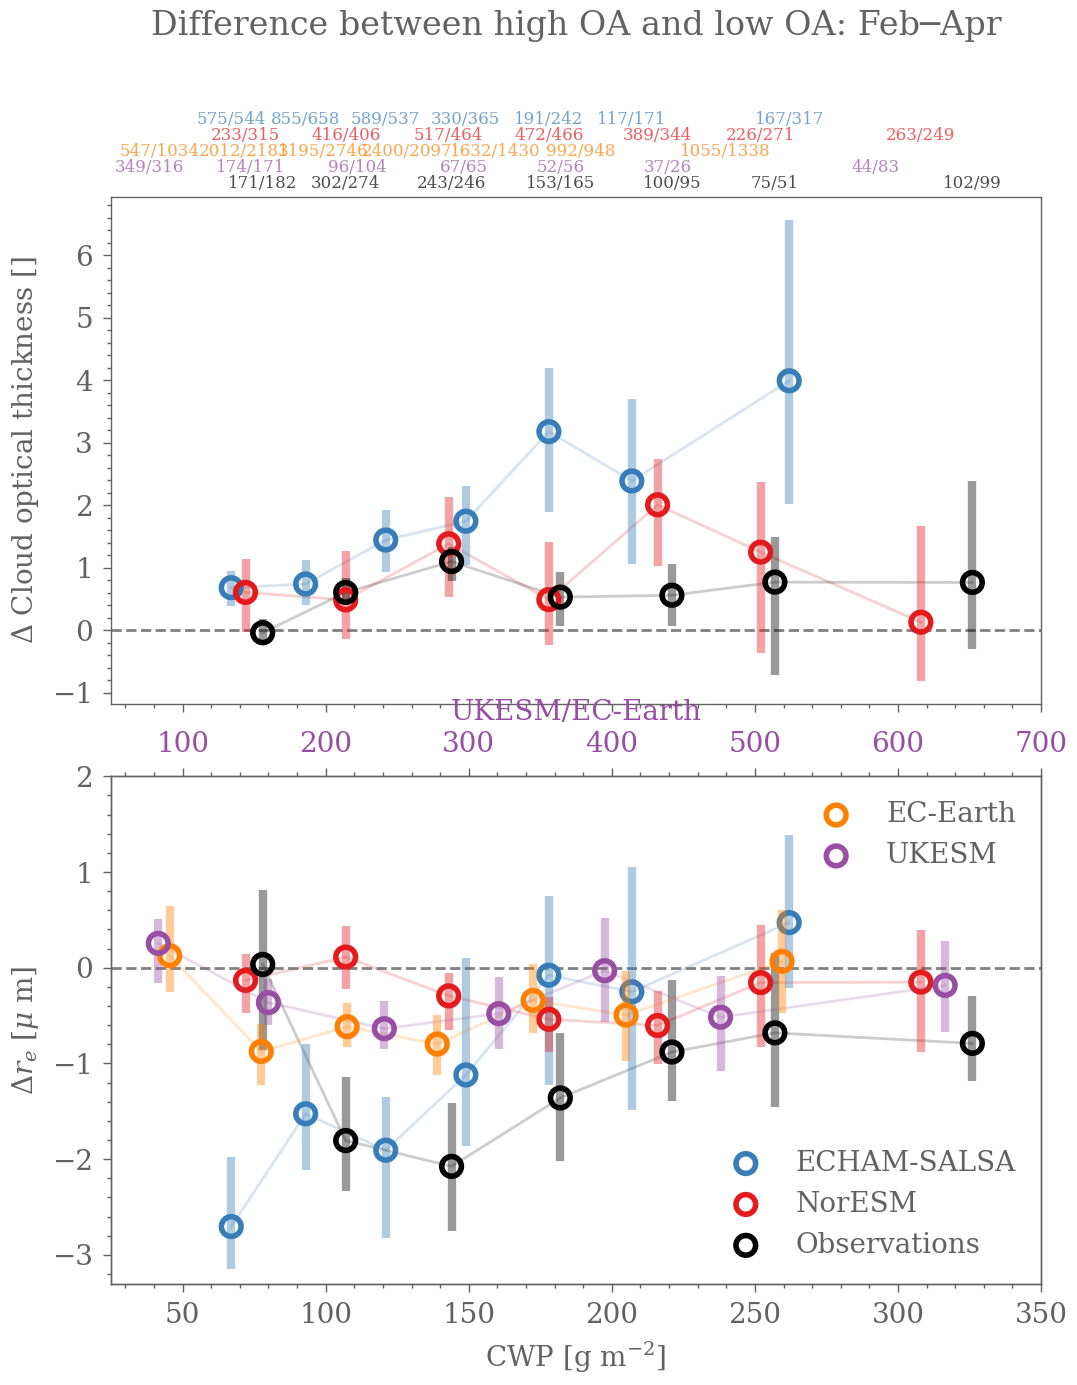

In [96]:
reduce_factor = 1
figsize = [6,8]
_palette = palette_OA_2
ylim = None#[0,25]
alpha_err=0.4
hue_lan_high= ['OA low', 'OA high']
hue_var = 'OA_category'

xlim = [25,350]
xlim2 = [50,700]
ylim2 =[-3.3,2]# [-4,4]
markersize= 2

fig, axs_all = plt.subplots(3,1,figsize=figsize, sharey='row', sharex='col', dpi=200, gridspec_kw={'height_ratios': [1, 7, 7]})

ax_num =axs_all[0]
ax_num_ukesm =axs_all[0].twiny()
axs = axs_all[[1,2]]

x_var = 'CWP_cut2lm'

y_var1 = 'COT'
y_var2 = 'r_eff'

ylab1 = r'$\Delta $ Cloud optical thickness []'
ylab2 = r'$\Delta r_e$ [$\mu$ m]'
y_pos = 0





for ax_use, y_var in zip(axs,[y_var1, y_var2]):
    if y_var !='COT':
        ax_use_twin = ax_use.twiny()

    
    for key in dic_df.keys():
        if (key in ['EC-Earth', 'UKESM']) and (y_var =='COT'):
            continue
        if key in ['UKESM','EC-Earth']:
            ax = ax_use_twin
            ax.set_xlabel('UKESM/EC-Earth', color=cdic_model[key], fontsize=10)  # we already handled the x-label with ax1
            ax.tick_params(axis='x', labelcolor=cdic_model[key])

        else:
            ax = ax_use
        diff_med = dic_median_CI[y_var][key]['sample_median']
        df_sample_quant = dic_median_CI[y_var][key]['bootstrap_quant']
        df_number = dic_median_CI[y_var][key]['number']

        df_bootstrap_med = df_sample_quant.loc[0.5]
        plt_med = diff_med[y_var]
        label = key
        #if key=='EC-Earth':
        #    label = f'{key}, 0.5CWP'
        ax.scatter(plt_med.index, plt_med, ec=cdic_model[key],lw=2, label=label,s=50,fc='none')
        ax.plot(plt_med.index, plt_med, c=cdic_model[key],lw=1, label='__nolegend__',zorder=-20,
               alpha=.2)
        #ax.scatter(df_bootstrap_med.index, df_bootstrap_med, c=cdic_model[key], label=key,s=200, marker='x')

        df_sample_quant_CI= df_sample_quant.drop(labels=0.5).T
        yerr = np.abs(df_sample_quant_CI.T - plt_med)
        
        ax.errorbar(plt_med.index, plt_med, yerr=yerr.values, 
                    #capsize=5,capthick=2,
                    c=cdic_model[key], linewidth=0, elinewidth=3, alpha=alpha_err,zorder=0)
        
        if y_var !=y_var2:
            continue
        df_number['n_str'] = df_number['n_low'].astype(str) + '/' + df_number['n_high'].astype(str) 
        #ax.text(df_numb.index, 

        for xi in df_number.index:

            si = df_number.loc[xi]['n_str']
            if key in ['UKESM','EC-Earth']:
                xi = xi*((xlim[1]-xlim2[0])/(xlim2[1]-xlim2[0]))
                #ax_num_ukesm.text(xi, y_pos, si,
                #    c = cdic_model[key],
                #        fontsize=6,
                #    horizontalalignment='center',
                #        alpha=.7,
                #   )
            #else:
            ax_num.text(xi, y_pos, si,
                    c = cdic_model[key],
                        fontsize=6,
                    horizontalalignment='center',
                        alpha=.7,
                           )
        #            transform=ax.transAxes,)
        y_pos -=.22
        
ax_num.xaxis.set_visible(False)
ax_num_ukesm.xaxis.set_visible(False)
ax_num.yaxis.set_visible(False)
ax_num_ukesm.yaxis.set_visible(False)
sns.despine(ax=ax_num,right=True, left = True, bottom=True, top=True)
sns.despine(ax=ax_num_ukesm,right=True, left = True, bottom=True, top=True)
for ax in axs:
    ax.axhline(0, c='.5',zorder=-10,lw=1, linestyle='--')
    
axs[0].set_ylabel(ylab1)
axs[1].set_ylabel(ylab2)
axs[1].set_ylim(ylim2)
axs[1].set_xlim(xlim)
ax_use_twin.set_xlim(xlim2)
axs[1].set_xlabel('CWP [g m$^{-2}$]')

ax.legend(loc=4, frameon=False)
ax_use_twin.legend(loc=1,frameon=False)

ax_num.set_title(f'Difference between high OA and low OA: {dic_season_nicename[season]}')

#ax_num.set_ylim([0,1])

#sns.despine(ax = axs[0])
#sns.despine(ax = axs[1])
fn = make_fn(hue_var, y_var1,x_var,comment=f'{y_var2}_diff_median', relplot=True)
#fig.subplots_adjust(hspace=.5)
print(fn)
#fig.savefig(fn, dpi=150)
#fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

Plots/rel_plot/cloud_props_r_eff_diff_median_full_OA_category_COT_CWP_cut2lm_FMA.png


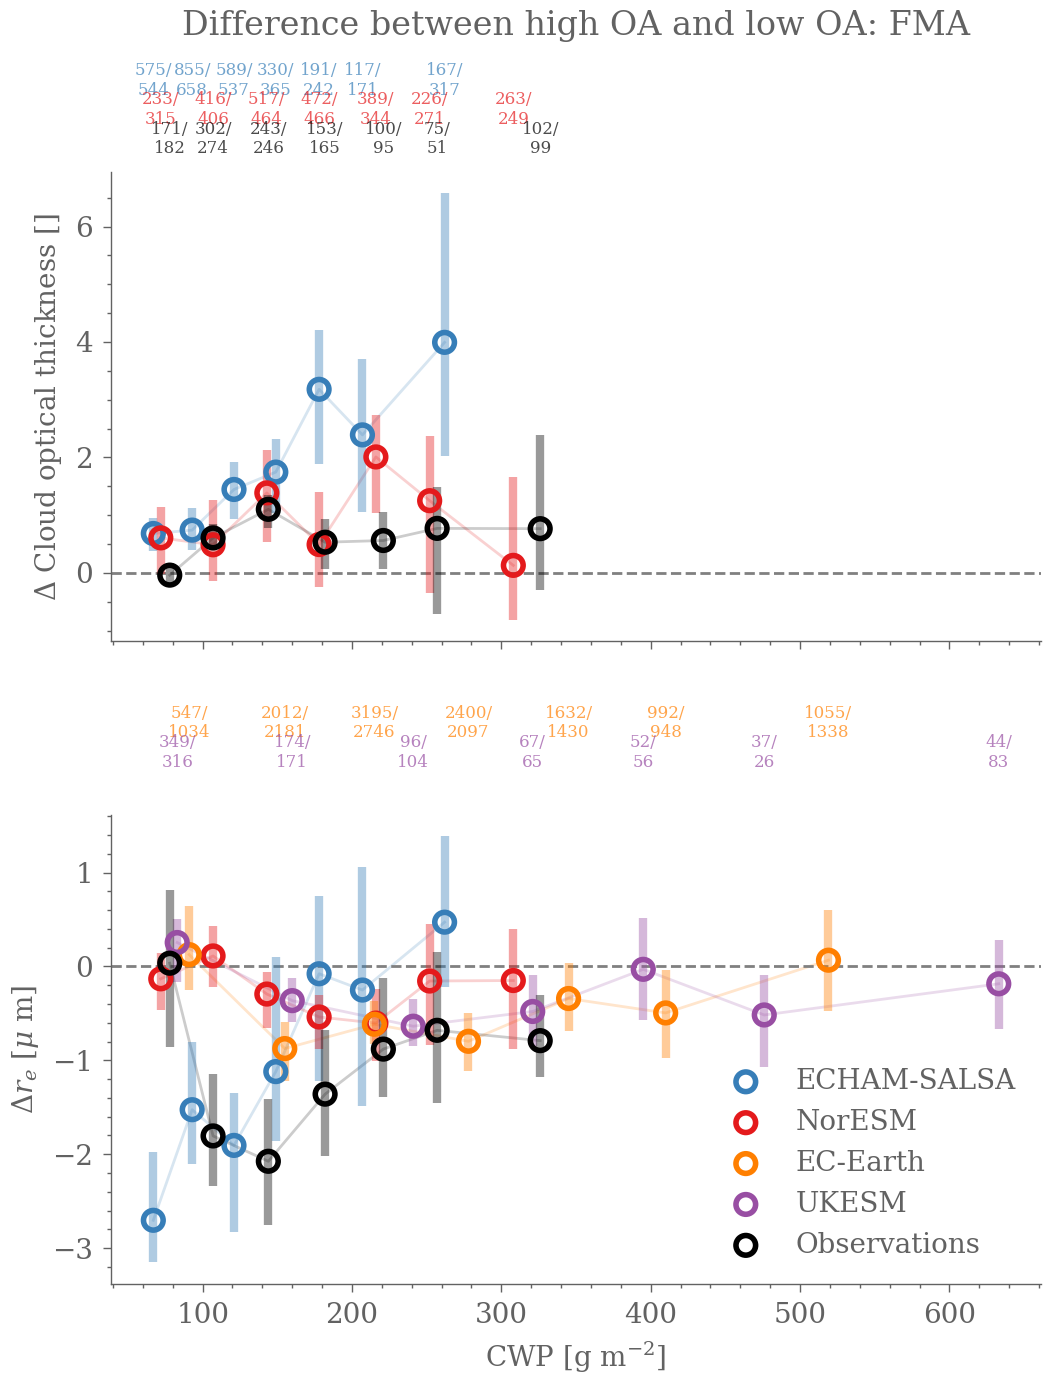

In [97]:
figsize = [6,8]
_palette = palette_OA_2
ylim = None#[0,25]
alpha_err=0.4
hue_lan_high= ['OA low', 'OA high']
hue_var = 'OA_category'

ylim2 =None# [-4,4]
markersize= 2

fig, axs_all = plt.subplots(4,1,figsize=figsize, sharey='row', sharex='col', dpi=200,
                            gridspec_kw={'height_ratios': [1, 7, 1,7]})

ax_num =axs_all[0]
ax_num2 = axs_all[2]
axs = axs_all[[1,3]]

x_var = 'CWP_cut2lm'

y_var1 = 'COT'
y_var2 = 'r_eff'

ylab1 = r'$\Delta $ Cloud optical thickness []'
ylab2 = r'$\Delta r_e$ [$\mu$ m]'
y_pos1 = .8
y_pos2 = .8

models_and_obs = list(dic_df.keys())
ax = axs[0]
for ax, y_var in zip(axs,[y_var1, y_var2]):
    
    
    for key in models_and_obs:
        if (key in ['EC-Earth', 'UKESM']) and (y_var =='COT'):
            continue
        diff_med = dic_median_CI[y_var][key]['sample_median']
        df_sample_quant = dic_median_CI[y_var][key]['bootstrap_quant']
        df_number = dic_median_CI[y_var][key]['number']

        df_bootstrap_med = df_sample_quant.loc[0.5]
        plt_med = diff_med[y_var]
        label = key
        #if key=='EC-Earth':
        #    label = f'{key}, 0.5CWP'
        ax.scatter(plt_med.index, plt_med, ec=cdic_model[key],lw=2, label=label,s=50,fc='none')
        ax.plot(plt_med.index, plt_med, c=cdic_model[key],lw=1, label='__nolegend__',zorder=-20,
               alpha=.2)
        #ax.scatter(df_bootstrap_med.index, df_bootstrap_med, c=cdic_model[key], label=key,s=200, marker='x')

        df_sample_quant_CI= df_sample_quant.drop(labels=0.5).T
        yerr = np.abs(df_sample_quant_CI.T - plt_med)
        
        ax.errorbar(plt_med.index, plt_med, yerr=yerr.values, 
                    #capsize=5,capthick=2,
                    c=cdic_model[key], linewidth=0, elinewidth=3, alpha=alpha_err,zorder=0)
        
        if y_var !=y_var2:
            continue
        df_number['n_str'] = df_number['n_low'].astype(str) + '/' + df_number['n_high'].astype(str) 
        #ax.text(df_numb.index, 
        if key in ['NorESM','ECHAM-SALSA', 'Observations']:
            _ax_num = ax_num
            y_pos1 -=.44
            y_pos = y_pos1
        else:
            _ax_num = ax_num2
            y_pos2 -=.44
            y_pos = y_pos2
        for xi in df_number.index:
            si = df_number.loc[xi]['n_str']
            si = '/\n'.join(si.split('/'))

            _ax_num.text(xi, y_pos, si,
                    c = cdic_model[key],
                        fontsize=6,
                    horizontalalignment='center',
                        alpha=.7,
                        zorder=1000000,
                   )
        #if key == models_and_obs[2]:
        #    y_pos = 0
        #else:
        y_pos -=.44
for _ax in [ax_num, ax_num2]:
    _ax.xaxis.set_visible(False)
    _ax.yaxis.set_visible(False)
    sns.despine(ax=_ax,right=True, left = True, bottom=True, top=True)
for ax in axs:
    ax.axhline(0, c='.5',zorder=-10,lw=1, linestyle='--')
    
axs[0].set_ylabel(ylab1)
axs[1].set_ylabel(ylab2)
axs[1].set_ylim(ylim2)

axs[1].set_xlabel('CWP [g m$^{-2}$]')

ax.legend(frameon=False)

ax_num.set_title(f'Difference between high OA and low OA: {season}')

#ax_num.set_ylim([0,1])

sns.despine(ax = axs[0])
sns.despine(ax = axs[1])
fn = make_fn(hue_var, y_var1,x_var,comment=f'{y_var2}_diff_median_full', relplot=True)
print(fn) 
#for ax in axs:
#    ax.set_xlim([50,450])

#fig.savefig(fn, dpi=150)
#fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

## Supplementary plots

In [98]:
hue_order = ['OA low','OA high']#[::-1]
palette_OA_2 = palette_OA[::-1]

In [99]:
order_keys = [model_name_noresm, model_name_echam, 'Observations']

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 21.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 18.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Plots/rel_plot/cloud_props_boxen_swarm_OA_category_COT_CWP_cutl_FMA.png


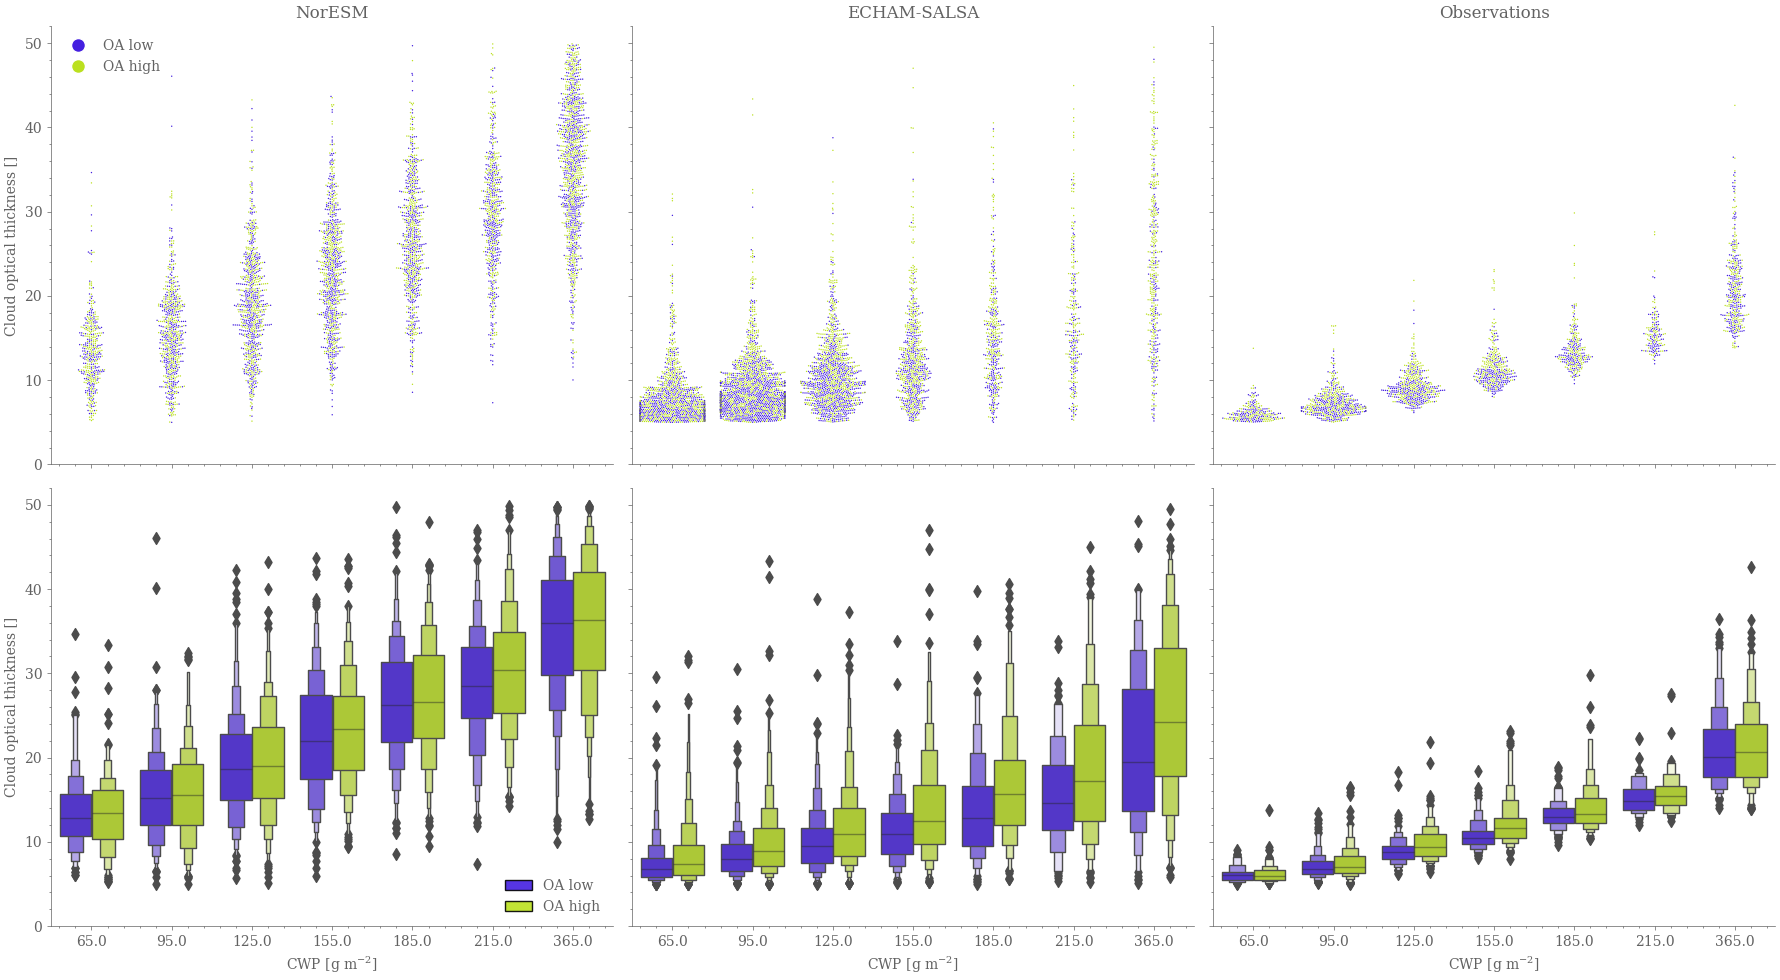

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_COT_CWP_cutl_FMA.png


In [100]:
x_var = 'CWP_cutl'
y_var = 'COT'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,52]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 1



for key,ax in zip(order_keys, axs[0,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

#for key,ax in zip(dic_df.keys(), axs[1,:]):
for key,ax in zip(order_keys, axs[1,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('Cloud optical thickness []')
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)


fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)

plt.show()
print(fn)
### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 13.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 17.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 12.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_FMA.png


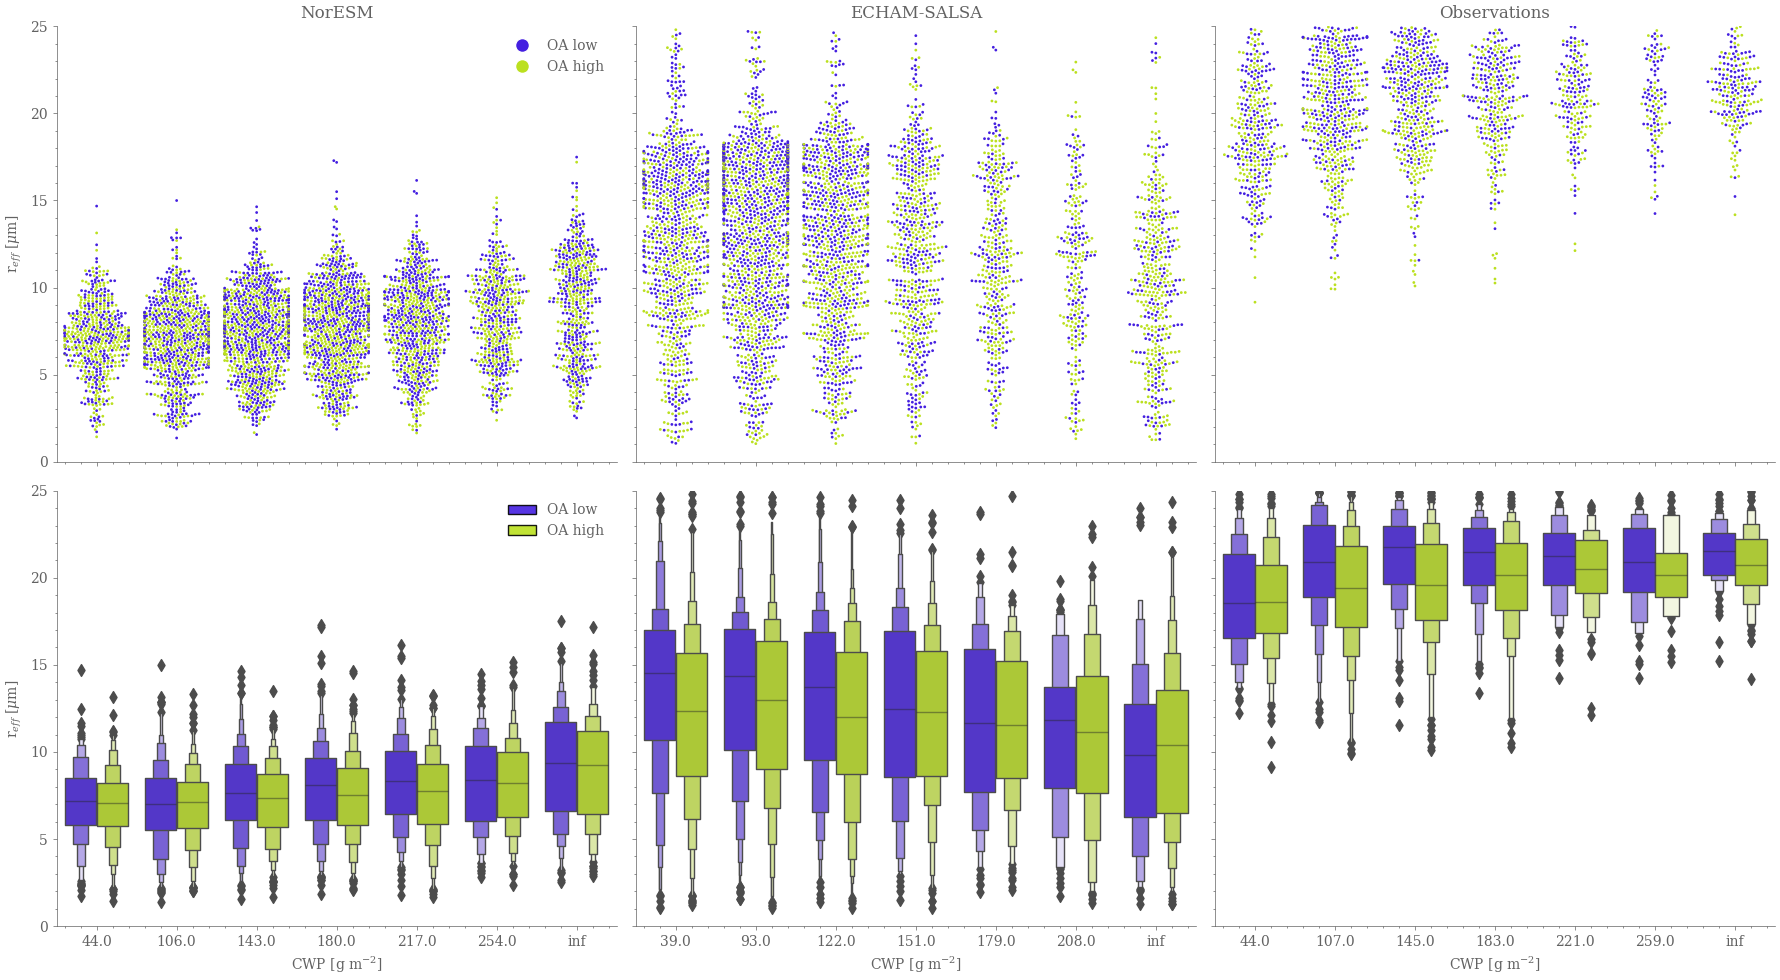

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_FMA.png


In [101]:
x_var = 'CWP_cut2lmid'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
#for key,ax in zip(dic_df.keys(), axs[0,:]):

    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(order_keys, axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('r$_{eff}$ [$\mu$m]')
    
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

sns.despine(fig)
fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()
print(fn)
### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 13.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 17.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 12.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_FMA.png


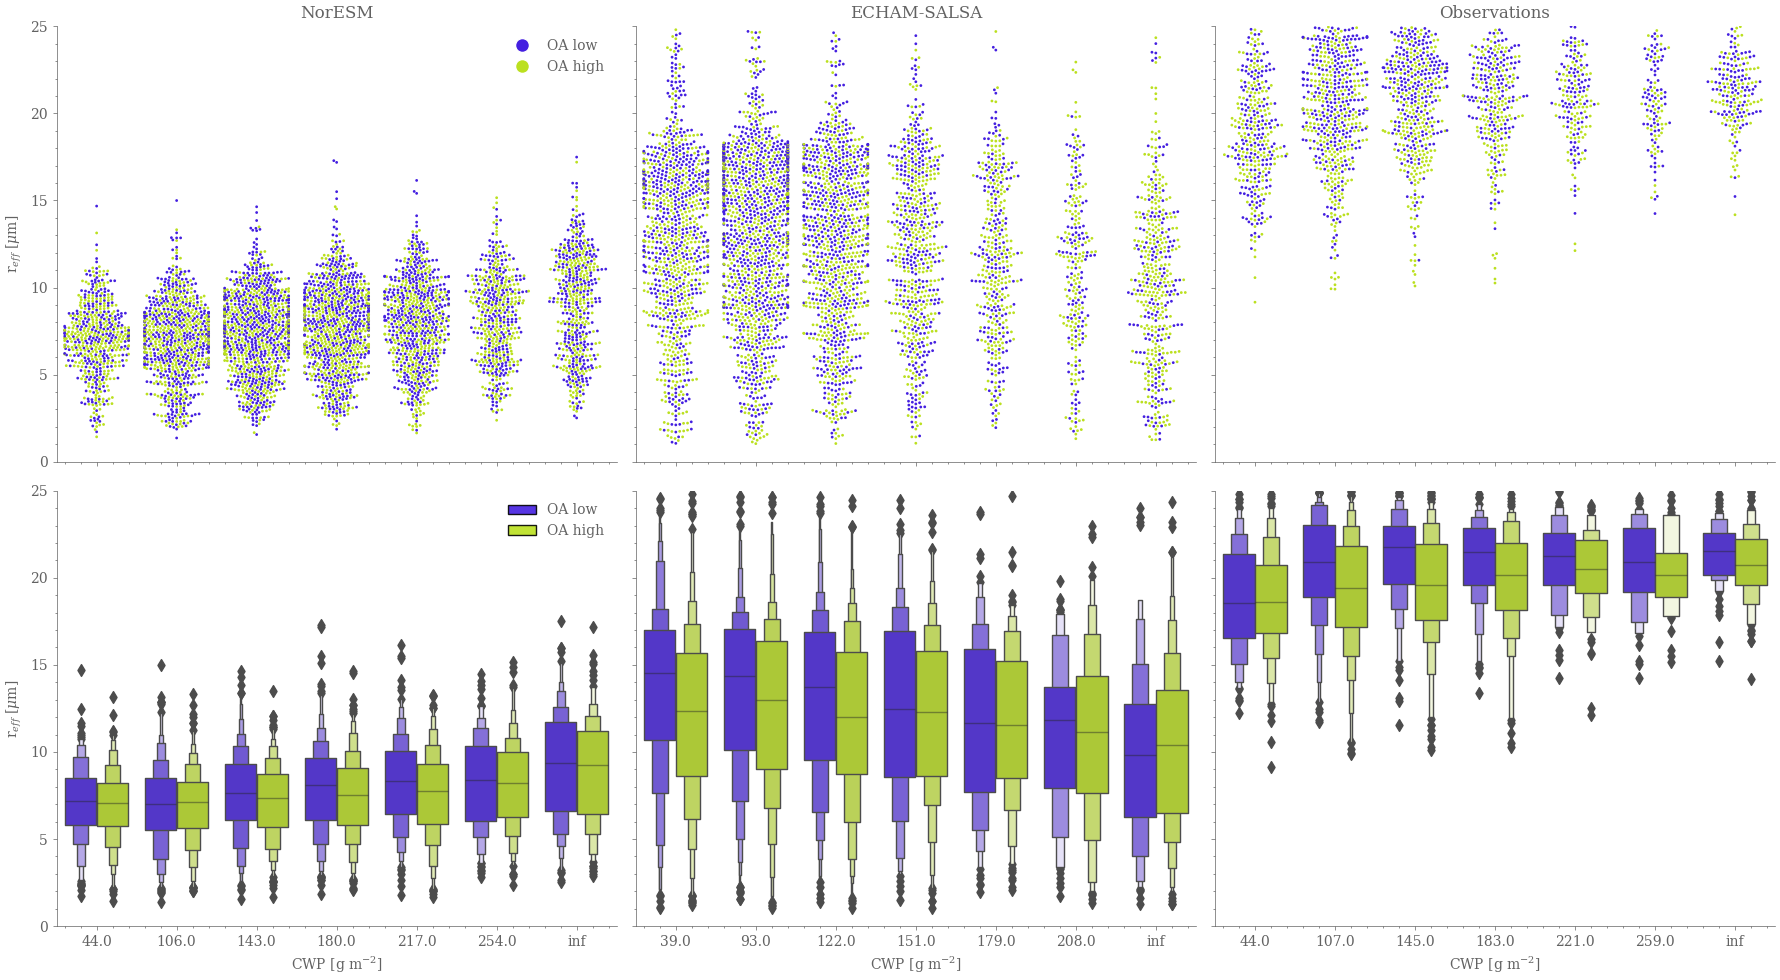

In [102]:
x_var = 'CWP_cut2lmid'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
#for key,ax in zip(dic_df.keys(), axs[0,:]):

    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(order_keys, axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('r$_{eff}$ [$\mu$m]')
    
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

sns.despine(fig)
fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

## Distribution of bootstrap median differences

length of 68 is 612 and 574
number of days is 182 and 204
50000
length of 95 is 875 and 680
number of days is 187 and 209
50000
length of 124 is 601 and 534
number of days is 178 and 197
50000
length of 153 is 298 and 376
number of days is 151 and 169
50000
length of 184 is 185 and 224
number of days is 107 and 135
50000
length of 214 is 104 and 174
number of days is 78 and 105
50000
length of 268 is 144 and 271
number of days is 88 and 129
50000


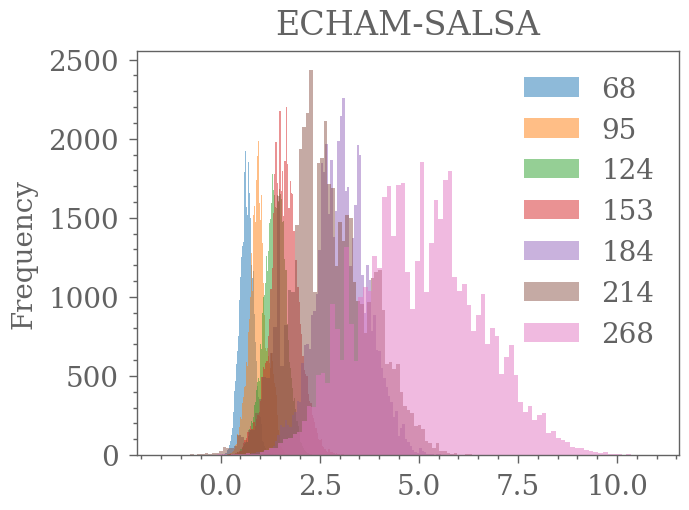

length of 68 is 177 and 230
number of days is 91 and 103
50000
length of 96 is 302 and 321
number of days is 125 and 134
50000
length of 126 is 390 and 375
number of days is 139 and 140
50000
length of 155 is 424 and 386
number of days is 136 and 138
50000
length of 184 is 361 and 360
number of days is 138 and 128
50000
length of 214 is 317 and 281
number of days is 134 and 112
50000
length of 269 is 545 and 562
number of days is 152 and 146
50000


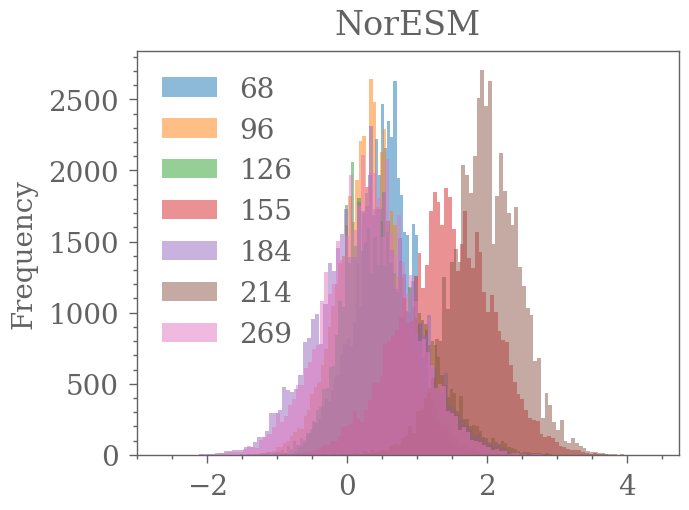

KeyError: 'COT'

In [103]:
x_var = 'CWP_cutlm'
y_var='COT'
itterations = 50000
for key in dic_df.keys():
    
    _df = dic_df[key].copy()
    
    _df_lim =_df.copy() 
    notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
    _df_lim = _df_lim[notna]
    
    _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
    _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
        
        
    df_sample_med =bootstrap_subset(_df_low,_df_high, 
                               #quantiles = None,
                               var=y_var, category=x_var, itts=itterations)

    
    
    for ca in df_sample_med.columns:
        df_sample_med[ca].plot.hist(alpha=0.5, label=ca, bins=100)
    plt.title(key)
    plt.legend()
    
    plt.show()